In [14]:
import sys, os, glob, warnings, logging
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sw_plotting import change_bar_width, plotCountBar
from sw_utilities import tukeyTest, getCountDFbyPrefix, get_annotated_countDF

# logging.basicConfig(stream=sys.stdout, format='%(asctime)s - %(levelname)s - %(message)s', level=logging.DEBUG)
# logging.basicConfig(stream=sys.stdout, format='%(asctime)s - %(levelname)s - %(message)s', level=logging.INFO)
logging.basicConfig(stream=sys.stdout, format='%(asctime)s - %(levelname)s - %(message)s', level=logging.ERROR)

# ignore warnings
warnings.filterwarnings('ignore')

# plotting configuration
font = {'family' : 'Arial',
        'size'   : 7}
matplotlib.rc('font', **font)
plt.rcParams['svg.fonttype'] = 'none'

# Make a folder if it is not already there to store exported figures
!mkdir ../jupyter_figures


mkdir: ../jupyter_figures: File exists


In [15]:
datasetFolder = '../data/220509-30-for-bud-count-Kaz/sg-Itgb1-time-course/'

files = glob.glob(os.path.join(datasetFolder, '*fileNameRecord.txt'))

datasetPrefixes = []
for f in files:
    datasetPrefixes.append('-'.join(os.path.basename(f).split('-')[:3]))

sgRNAs = ["sg-Control"]*5 + ["sg1-Itgb1"]*5 + ["sg2-Itgb1"]*5 + ["sg3-Itgb1"]*5
dfs = []
for datasetPrefix in datasetPrefixes:
    dfs.append( get_annotated_countDF(datasetPrefix, datasetFolder, sgRNAs) )

df = pd.concat(dfs)
df.reset_index(drop=True, inplace=True)
df_Kaz = df

In [16]:
datasetFolder = '../data/220509-30-for-bud-count-Rei/sg-Itgb1-time-course/'

files = glob.glob(os.path.join(datasetFolder, '*fileNameRecord.txt'))

datasetPrefixes = []
for f in files:
    datasetPrefixes.append('-'.join(os.path.basename(f).split('-')[:3]))

sgRNAs = ["sg-Control"]*5 + ["sg1-Itgb1"]*5 + ["sg2-Itgb1"]*5 + ["sg3-Itgb1"]*5
dfs = []
for datasetPrefix in datasetPrefixes:
    dfs.append( get_annotated_countDF(datasetPrefix, datasetFolder, sgRNAs) )

df = pd.concat(dfs)
df.reset_index(drop=True, inplace=True)
df_Rei = df

In [17]:
df.columns

Index(['file_name', 'scrambled_file_name', 'counts', 'sample_id', 'sgRNA',
       'time_d', 'groups'],
      dtype='object')

In [18]:
# Merge the two data set and compare the countings of Rei and Kaz
df_Kaz.rename(columns={'counts': 'counts_Kaz'}, inplace=True)
df_Rei.rename(columns={'counts': 'counts_Rei'}, inplace=True)
df = df_Kaz.merge(df_Rei, on=['file_name',
                              'scrambled_file_name',
                              'sample_id',
                              'sgRNA',
                              'time_d',
                              'groups'])
df.head()

,file_name,scrambled_file_name,counts_Kaz,sample_id,sgRNA,time_d,groups,counts_Rei
0,Plate07152021_WellD02_ChannelMono_Seq0000.nd2,7c0bdcf17473df8ac66bffb380235882.nd2,12,plate5_1_01,sg-Control,1,sg-Control_1,10
1,Plate07152021_WellD03_ChannelMono_Seq0001.nd2,a3c93853407b0271087d2a9fc3d1d9a3.nd2,2,plate5_1_02,sg-Control,1,sg-Control_1,3
2,Plate07152021_WellD04_ChannelMono_Seq0002.nd2,62df7a46ec86a9af8b3f84077cfec6b5.nd2,9,plate5_1_03,sg-Control,1,sg-Control_1,9
3,Plate07152021_WellD05_ChannelMono_Seq0003.nd2,107cc7d771fde6944cfac121e3a55378.nd2,4,plate5_1_04,sg-Control,1,sg-Control_1,4
4,Plate07152021_WellD06_ChannelMono_Seq0004.nd2,96a4a80dd34cb85d2558bef101af734d.nd2,7,plate5_1_05,sg-Control,1,sg-Control_1,6


In [19]:
# exclude the samples where the sample is outside
# the field of view or severely off-focus
samples_to_exclue = ['plate5_1_09',
                     'plate6_1_04',
                     'plate6_1_12',
                     # 'plate6_2_01', # partial view
                     # 'plate6_2_02', # partial view
                     'plate6_2_04',
                     'plate7_3_10'
                    ]
df = df[~df.sample_id.isin(samples_to_exclue)]

In [20]:
# calculate average counting data
df['counts'] = (df['counts_Rei'] + df['counts_Kaz']) / 2

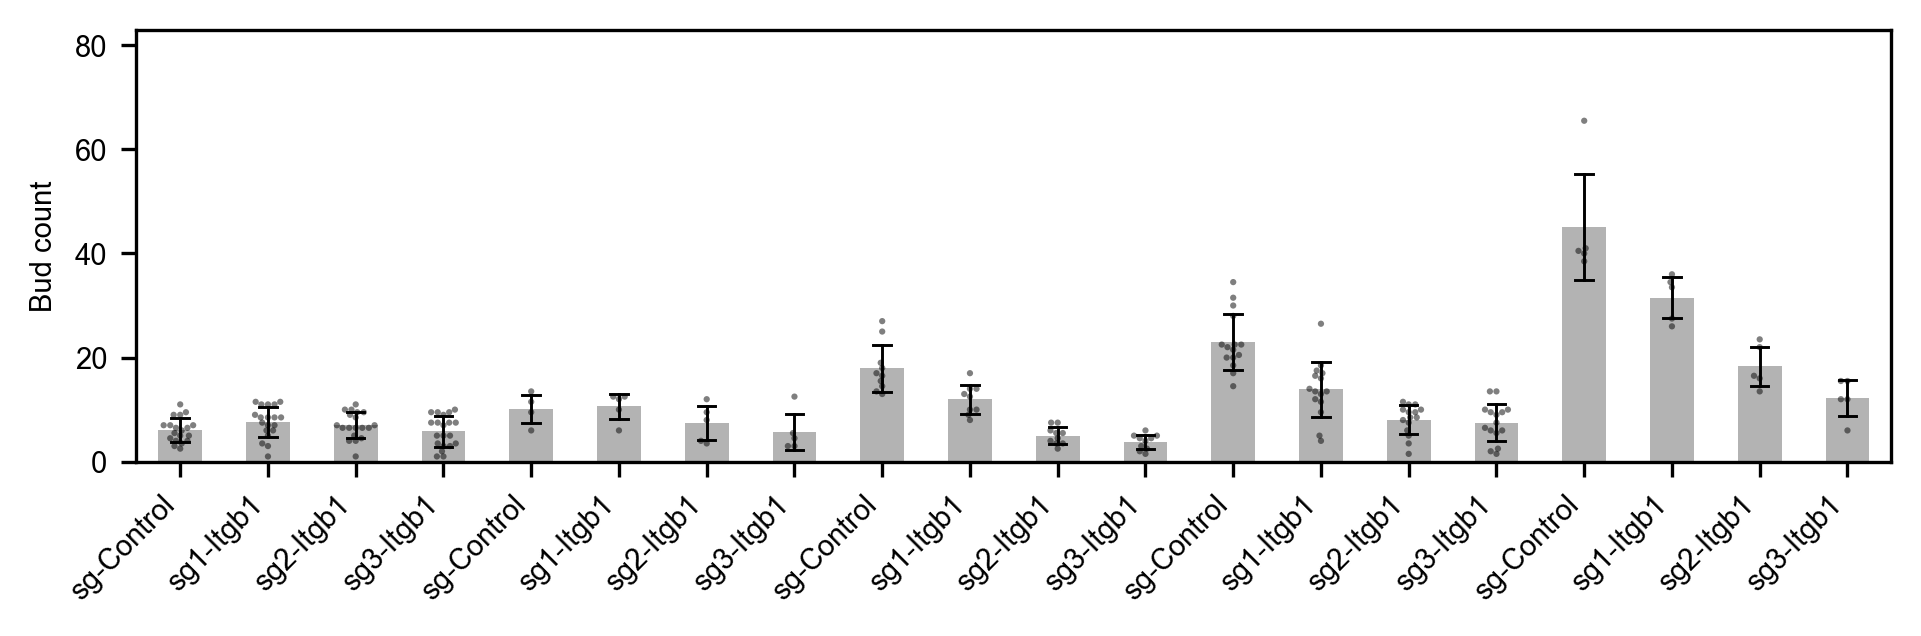

In [21]:
# Make plot for figure

fig_width, fig_height = 6.5, 1.8 # inches
line_width = .8
output_prefix = '220516-22-plates-5-8-time-course-Itgb1'
outputFigPath = '../jupyter_figures/' + output_prefix + '.svg'
# outputFigPath = '../jupyter_figures/' + output_prefix + '.tif'

fig = plt.figure(figsize=(fig_width,fig_height), dpi=300)
ax = fig.add_axes([0.10, 0.15, 0.9, 0.8])

sns.swarmplot(data = df,
              x = 'groups', y = 'counts',
              size = 1.5,
              color = 'k',
              alpha = .5
             )
sns.barplot(data = df,
            x = 'groups', y = 'counts',
            ci = 'sd',
            color=".7", # This a nicer looking lighter gray to my own taste
            errwidth=.7,
            errcolor="k",
            capsize=.2)

change_bar_width(ax, .5)

plt.ylim(0, 83)

# rotate x tick labels if necessary
x_labels = ax.get_xticklabels()
x_labels_short = [i.get_text()[:-2] for i in x_labels]
ax.set_xticklabels(labels=x_labels_short, rotation=45, ha="right")

plt.xlabel("")
plt.ylabel("Bud count")

# ax.get_legend().remove()

for o in fig.findobj():
    o.set_clip_on(False)
for o in ax.findobj():
    o.set_clip_on(False)

plt.savefig(outputFigPath)

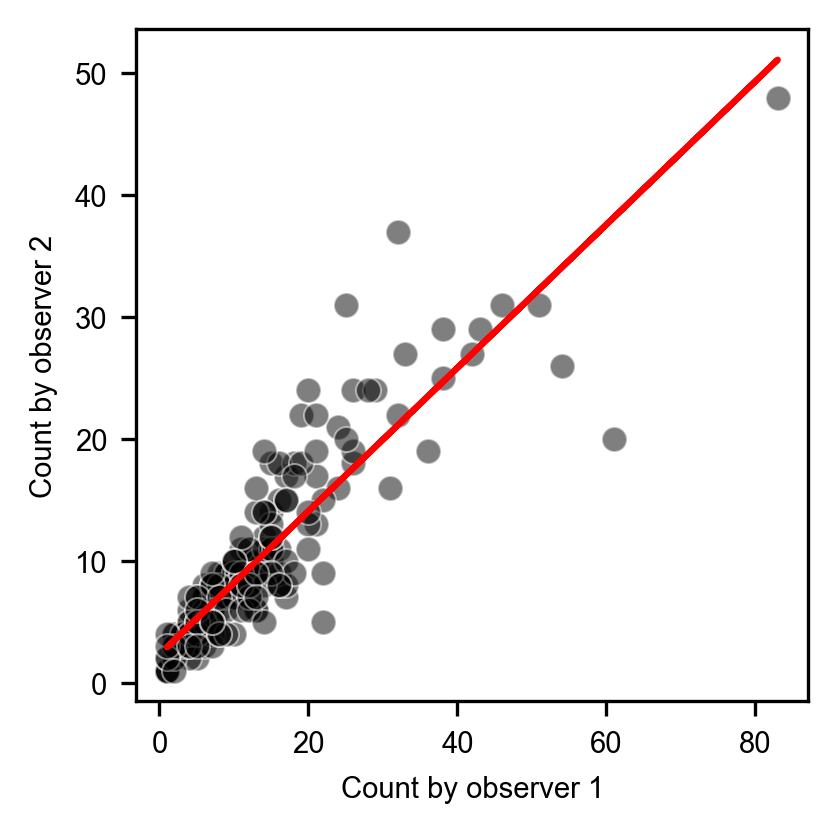

In [22]:
# Make plot for figure

fig_width, fig_height = 2.8, 2.8 # inches
line_width = .8
output_prefix = '220516-22-plates-5-8-time-course-Itgb1-Kaz-vs-Rei'
outputFigPath = '../jupyter_figures/' + output_prefix + '.svg'
# outputFigPath = '../jupyter_figures/' + output_prefix + '.tif'

fig = plt.figure(figsize=(fig_width,fig_height), dpi=300)
ax = fig.add_axes([0.15, 0.15, 0.8, 0.8])

sns.scatterplot(data = df,
                x = 'counts_Kaz', y = 'counts_Rei',
                # size = 1.5,
                color = 'k',
                alpha = .5
               )

from scipy import stats

x = df.counts_Kaz
y = df.counts_Rei
res = stats.linregress(x, y)

plt.plot(x, res.intercept + res.slope*x, 'r', label='fitted line')

# plt.xlim(0, 45)
# plt.ylim(0, 45)

# ax.set_xticks([0, 10, 20, 30, 40])
# ax.set_yticks([0, 10, 20, 30, 40])           

plt.xlabel("Count by observer 1")
plt.ylabel("Count by observer 2")

# ax.get_legend().remove()

for o in fig.findobj():
    o.set_clip_on(False)
for o in ax.findobj():
    o.set_clip_on(False)

plt.savefig(outputFigPath)

In [10]:
res

LinregressResult(slope=0.5877391635433826, intercept=2.3240703681715598, rvalue=0.8892705094017354, pvalue=2.6732652127713575e-74, stderr=0.020712840571824823)

In [11]:
res.rvalue**2

0.7908020388916219

In [12]:
for day in df.time_d.unique():
    df_temp = df[df.time_d == day]
    print('Stats for day', day)
    tukeyTest(df_temp.counts, df_temp.groups)

Stats for day 1
Summary of test:
      Multiple Comparison of Means - Tukey HSD, FWER=0.05      
   group1       group2   meandiff p-adj   lower  upper  reject
--------------------------------------------------------------
sg-Control_1 sg1-Itgb1_1   1.5526 0.3107  -0.793 3.8982  False
sg-Control_1 sg2-Itgb1_1   0.8947 0.7235 -1.4509 3.2404  False
sg-Control_1 sg3-Itgb1_1  -0.2539    0.9 -2.5701 2.0622  False
 sg1-Itgb1_1 sg2-Itgb1_1  -0.6579  0.871 -3.0035 1.6877  False
 sg1-Itgb1_1 sg3-Itgb1_1  -1.8066 0.1792 -4.1227 0.5095  False
 sg2-Itgb1_1 sg3-Itgb1_1  -1.1487 0.5563 -3.4648 1.1674  False
--------------------------------------------------------------
p values of all pair-wise tests:
 [0.31073869 0.72353663 0.9        0.87100081 0.17918108 0.55630895]
Stats for day 2
Summary of test:
       Multiple Comparison of Means - Tukey HSD, FWER=0.05      
   group1       group2   meandiff p-adj   lower   upper  reject
---------------------------------------------------------------
sg-Contr

In [13]:
len(df)

215

In [23]:
for i in df.groups.unique():
    print(i, ' n =', len(df[df.groups==i]))

sg-Control_1  n = 19
sg1-Itgb1_1  n = 19
sg2-Itgb1_1  n = 19
sg3-Itgb1_1  n = 20
sg-Control_2  n = 4
sg1-Itgb1_2  n = 5
sg2-Itgb1_2  n = 5
sg3-Itgb1_2  n = 5
sg-Control_3  n = 10
sg1-Itgb1_3  n = 9
sg2-Itgb1_3  n = 10
sg3-Itgb1_3  n = 10
sg-Control_4  n = 15
sg1-Itgb1_4  n = 15
sg2-Itgb1_4  n = 15
sg3-Itgb1_4  n = 15
sg-Control_7  n = 5
sg1-Itgb1_7  n = 5
sg2-Itgb1_7  n = 5
sg3-Itgb1_7  n = 5
